# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.


### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset

In [1]:
# Se importan todas las librerías a utilizar durante el proyecto.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
import datetime
import warnings
warnings.filterwarnings('ignore')

a- Importamos los datasets que vamos a utilizar. En este caso: 2017, 2018, 2019.

In [2]:
data_2019 = pd.read_csv(r'C:\Users\GASTON\Desktop\Proyecto 3\flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv(r'C:\Users\GASTON\Desktop\Proyecto 3\flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv(r'C:\Users\GASTON\Desktop\Proyecto 3\flujo-vehicular-2017.csv', sep =',')

In [3]:
# Analizamos los tipos de datos presentes, e imprimimos los primeros registros del dataset de 2019.

data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


In [4]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,NO COBRADO,29
1,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,TELEPASE,9
2,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,NO COBRADO,73
3,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,TELEPASE,39
4,2018,2018-01-01,2,3,Lunes,Alberdi,Centro,Liviano,NO COBRADO,115


In [5]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94


Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [6]:
print('Las estaciones de peaje en el dataset para cada año:')
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

Las estaciones de peaje en el dataset para cada año:
['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [7]:
print('Los sentidos posibles dentro del dataset:')
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

Los sentidos posibles dentro del dataset:
['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [8]:
print('Los tipos de vehiculos dentro del dataset:')
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

Los tipos de vehiculos dentro del dataset:
['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [9]:
print('Formas de pago:')
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

Formas de pago:
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**

In [10]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
80,2019-01-01,2,Martes,Centro,Liviano,537
86,2019-01-01,2,Martes,Centro,Pesado,1
88,2019-01-01,2,Martes,Provincia,Liviano,443
94,2019-01-01,2,Martes,Provincia,Pesado,1
149,2019-01-01,3,Martes,Centro,Liviano,769


In [11]:
# Verificamos la cantidad de filas y columnas que tiene el dataset.
dataset.shape

(238869, 6)

In [12]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [13]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [14]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
1,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00
2,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
3,Domingo,Provincia,Pesado,6,2017-01-01 00:00:00
4,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
...,...,...,...,...,...
238864,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
238865,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
238866,Martes,Centro,Liviano,580,2019-12-31 22:00:00
238867,Martes,Centro,Liviano,214,2019-12-31 23:00:00


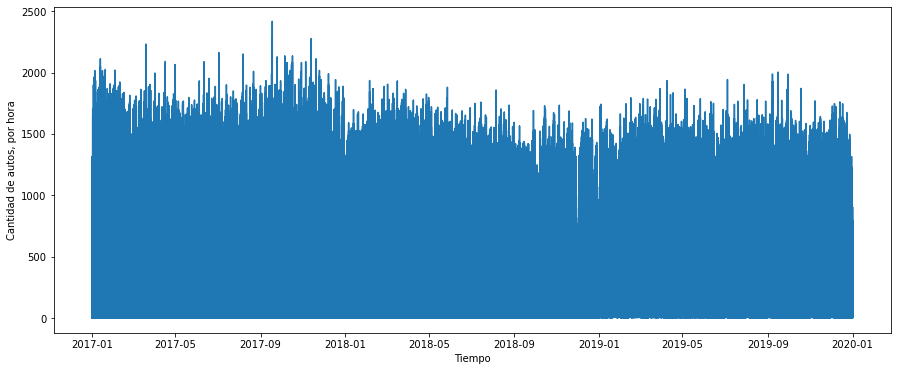

In [15]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

## Cuales son los días y horas de mayor tráfico

In [16]:
# Resampleamos nuestros datos para agrupar por dia y de esa manera lograr una mejor visualización.
# Además, luego de este proceso queda seteada la fecha como índice, lo que es adecuado para continuar con el proceso de trabajo con Series de Tiempo.
# Los datos quedan ordenados cronologicamente, indicando la cantidad de autos que pasaron cada día. Se considera sólo Autopista Illia (pago en efectivo).

diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


In [17]:
# Se genera una copia del DataFrame para no modificarlo ya que será utilizado más avanzado el presente proyecto.

diario2=diario.copy()

In [18]:
# Se generan nuevas columnas que indiquen el día de la semana, número de la misma, año, y hora del registro.

diario2['dia_semana']  = diario2.index.weekday
diario2['numero_semana'] = diario2.index.week
diario2['año'] = diario2.index.year
diario2['hora'] = diario2.index.hour
diario2.head()

,cantidad_pasos,dia_semana,numero_semana,año,hora
fecha,,,,,
2017-01-01,31183,6,52,2017,0
2017-01-02,51568,0,1,2017,0
2017-01-03,51093,1,1,2017,0
2017-01-04,53332,2,1,2017,0
2017-01-05,56486,3,1,2017,0


In [19]:
# Se genera un DataFrame para cada año.

diario2_2017 = diario2[diario2['año']==2017]
diario2_2018 = diario2[diario2['año']==2018]
diario2_2019 = diario2[diario2['año']==2019]

In [20]:
# Se generan tablas pivot, para ver la cantidad de vehiculos que pasan cada día de la semana.
# Las tablas pivot son una muy buena herramienta para la respuesta de preguntas que requieran el análisis desde varios puntos de vista.

pivot_2017 = diario2_2017.pivot_table(values='cantidad_pasos', index='dia_semana', columns='numero_semana')
pivot_2018 = diario2_2018.pivot_table(values='cantidad_pasos', index='dia_semana', columns='numero_semana')
pivot_2019 = diario2_2019.pivot_table(values='cantidad_pasos', index='dia_semana', columns='numero_semana')

Text(0, 0.5, 'Cantidad de pasos por peaje')

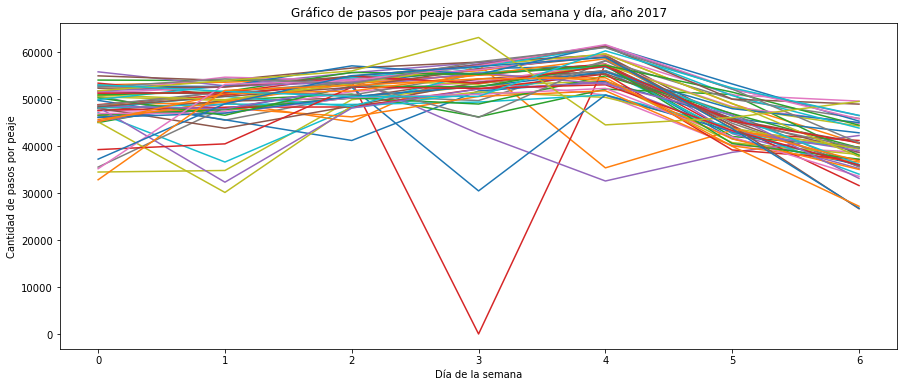

In [21]:
# Imprimimos en pantalla el gráfico de pasos por día de la semana, para cada una de las semanas de los años 2017, 2018 y 2019.

pivot_2017.plot(figsize=(15,6))
plt.legend().remove()
plt.title('Gráfico de pasos por peaje para cada semana y día, año 2017')
plt.xlabel('Día de la semana')
plt.ylabel('Cantidad de pasos por peaje')

Text(0, 0.5, 'Cantidad de pasos por peaje')

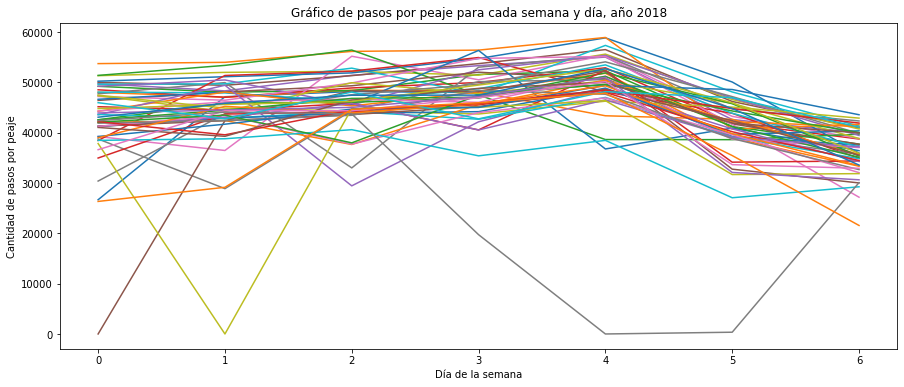

In [22]:
pivot_2018.plot(figsize=(15,6))
plt.legend().remove()
plt.title('Gráfico de pasos por peaje para cada semana y día, año 2018')
plt.xlabel('Día de la semana')
plt.ylabel('Cantidad de pasos por peaje')

Text(0, 0.5, 'Cantidad de pasos por peaje')

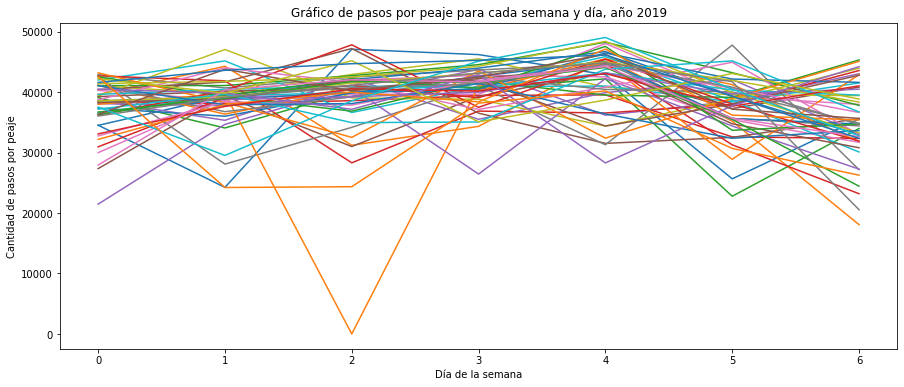

In [23]:
pivot_2019.plot(figsize=(15,6))
plt.legend().remove()
plt.title('Gráfico de pasos por peaje para cada semana y día, año 2019')
plt.xlabel('Día de la semana')
plt.ylabel('Cantidad de pasos por peaje')

#### ¿Cuáles son los días de la semana con mayor flujo vehicular en autopista Illia con pago en efectivo?

* Días de más pasos vehiculares en la semana: como se puede apreciar en los gráficos de los años 2017, 2018 y 2019, pareciera existir un flujo vehicular creciente a partir del lunes hasta el viernes. Luego existe un menor flujo de vehiculos los días sábados, llegando al día de menor tráfico que es el día 6, osea Domingo. 

* Se pueden apreciar datos que podríamos considerar como outliers, con valores de 0 pasos en el día. Estos datos será muy recomendable tratarlos en pasos posteriores para que no afecten la eficiencia del modelo predictivo que se requiera utilizar.

#### ¿Cuáles son las horas de mayor tráfico vehicular en Illia con pago en efectivo?

* Considerando una repetitividad evidente en el comportamiento semanal, como vimos en el punto anterior, para el caso de pasos vehiculares por hora se decide tomar una muestra de días, ya que entre ellos será similar según la ubicación del mismo dentro de la semana. Una vez seleccionada la muestra de días que vamos a utilizar, se procede a analizar los pasos horarios de vehículos. 

In [24]:
dataset.set_index('fecha', inplace=True)
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos
fecha,,,,
2017-01-01,Domingo,Provincia,Pesado,1
2017-01-01,Domingo,Provincia,Liviano,9
2017-01-01,Domingo,Provincia,Liviano,644
2017-01-01,Domingo,Provincia,Pesado,6
2017-01-01,Domingo,Provincia,Pesado,1


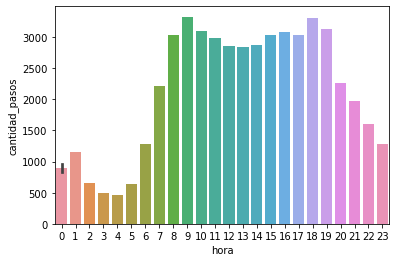

In [25]:
# Se agrupan los pasos vehiculares dentro de un día en particular por hora, y se grafica.
# Se analizaron varios días para verificar el comportamiento similar, dejando uno en particular impreso en pantalla. 

dataset_agrupado_index = dataset.groupby(by=dataset.index).sum()
dia_prueba= dataset_agrupado_index.loc['2017-01-02 00:00:00':'2017-01-03 00:00:00']
dia_prueba['hora'] = dia_prueba.index.hour
ax_3= sns.barplot(data=dia_prueba, x='hora', y='cantidad_pasos')

* Luego de realizar múltiples pruebas en distintos días, se podría aproximar que las horas de mayor tráfico se encuentran entre las 8hs y 19hs.
* Esto está claramente relacionado con los horarios laborales en Argentina. 
* Alrededor de las 8hs se puede aproximar al ingreso laboral, y las 19hs al horario de salida. Por lo cual en las horas intermedias existe como una disminución parcial en la circulación.
* Hipotesis: seguramente el flujo vehicular a las 8hs sea mayor en sentido centro, y a las 19hs en sentido hacia provincia, por una cuestión de ubicación de la mayor cantidad de empleos en Buenos Aires. Quedaría pendiente realizar nuevas pruebas para poder afirmar o rechazar dicha hipotesis.
* También se relaciona con la caída de tráfico en los días sábados y domingos, en los cuales el tráfico por cuestiones laborales es inferior.
* Para un modelo para puesta en producción sería muy recomendable, utilizar uno para el flujo hacia el centro de la capital y otro para la salida, ya que el comportamiento horario es opuesto en ambos.

# Componentes de la serie

* Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).

## Tendencia de los datos

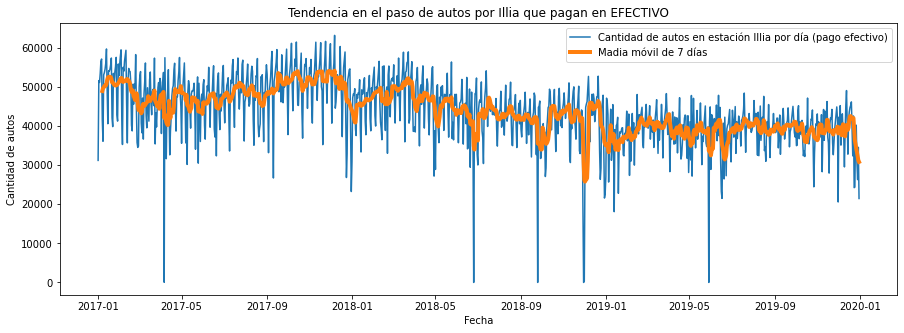

In [26]:
# Calculamos el promedio de los últimos 7 días (ventana), para generar una media móvil de 7 periodos.
# Se considera utilizar 7 días para la media móvil, como un estimado semanal.

ventana = 7
diario_promedio_tendencia = diario.cantidad_pasos.rolling(window=ventana).mean()
diario_promedio_tendencia.head(n=2)

# Gráficamos la media móvil obtenida, junto a los datos diarios para Illia con pago en efectivo.

plt.figure(figsize = (15,5))
plt.plot(diario.index, diario.cantidad_pasos, label = 'Cantidad de autos en estación Illia por día (pago efectivo)')
plt.plot(diario_promedio_tendencia, lw = 4, label = 'Madia móvil de 7 días')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de autos')
plt.legend()
plt.title('Tendencia en el paso de autos por Illia que pagan en EFECTIVO')
plt.show()

Una visualización interesante se logra si a la serie original le restamos la tendencia de 7 días. De esa manera estamos eliminando la componente tendencial de la serie de tiempo, y nos quedamos con una serie estacionaria.

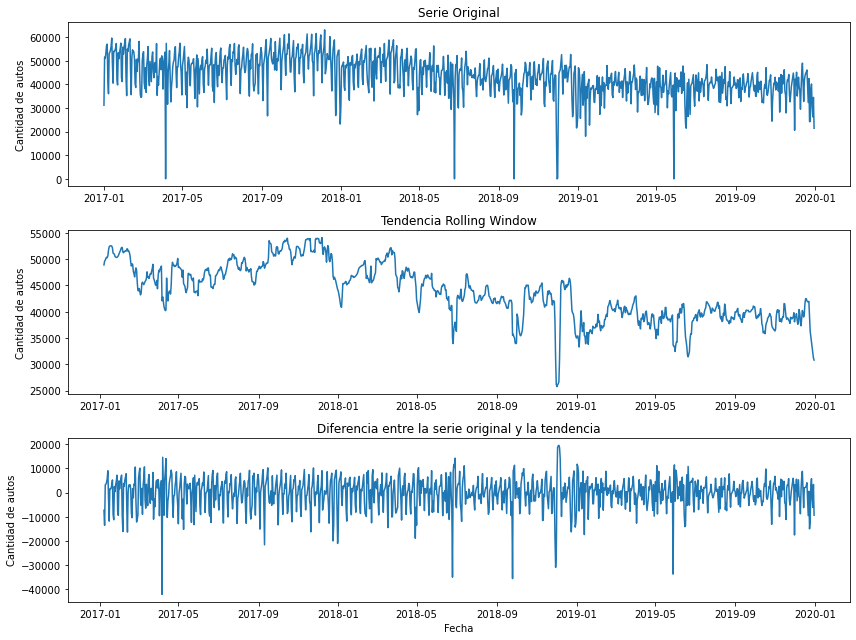

In [27]:
# Diferencia entre serie original y la tendencia de 30 días.

plt.figure(figsize = (12,9))

plt.subplot(3,1,1)
plt.title('Serie Original')
plt.plot(diario.index, diario.cantidad_pasos)
plt.ylabel('Cantidad de autos')

plt.subplot(3,1,2)
plt.title('Tendencia Rolling Window')
plt.plot(diario_promedio_tendencia)
plt.ylabel('Cantidad de autos')

plt.subplot(3,1,3)
plt.title('Diferencia entre la serie original y la tendencia')
plt.plot(diario.index, diario.cantidad_pasos - diario_promedio_tendencia)
plt.xlabel('Fecha')
plt.ylabel('Cantidad de autos')

plt.tight_layout()
plt.show()

* **Tendencia**: con respecto a la visualización anterior se puede apreciar una tendencia decreciente en el tiempo. Hay que tener en cuenta que sólo estamos considerando un sólo medio de pago (efectivo). Una de las hipotesis que podemos plantear es que los usuarios estén migrando a nuevos sistemas de pagos más allá de efectivo. Igualmente procedemos a descomponer la serie de tiempo en sus distintos componentes además de la tendencia.

## Componentes de la serie de tiempo

* Se procede a utilizar Seasonal Decompose para obtener además de la tendencia los otros componentes de la Serie de Tiempo: componente cíclica y residual o componente irregular.

Text(0, 0.5, 'Residual')

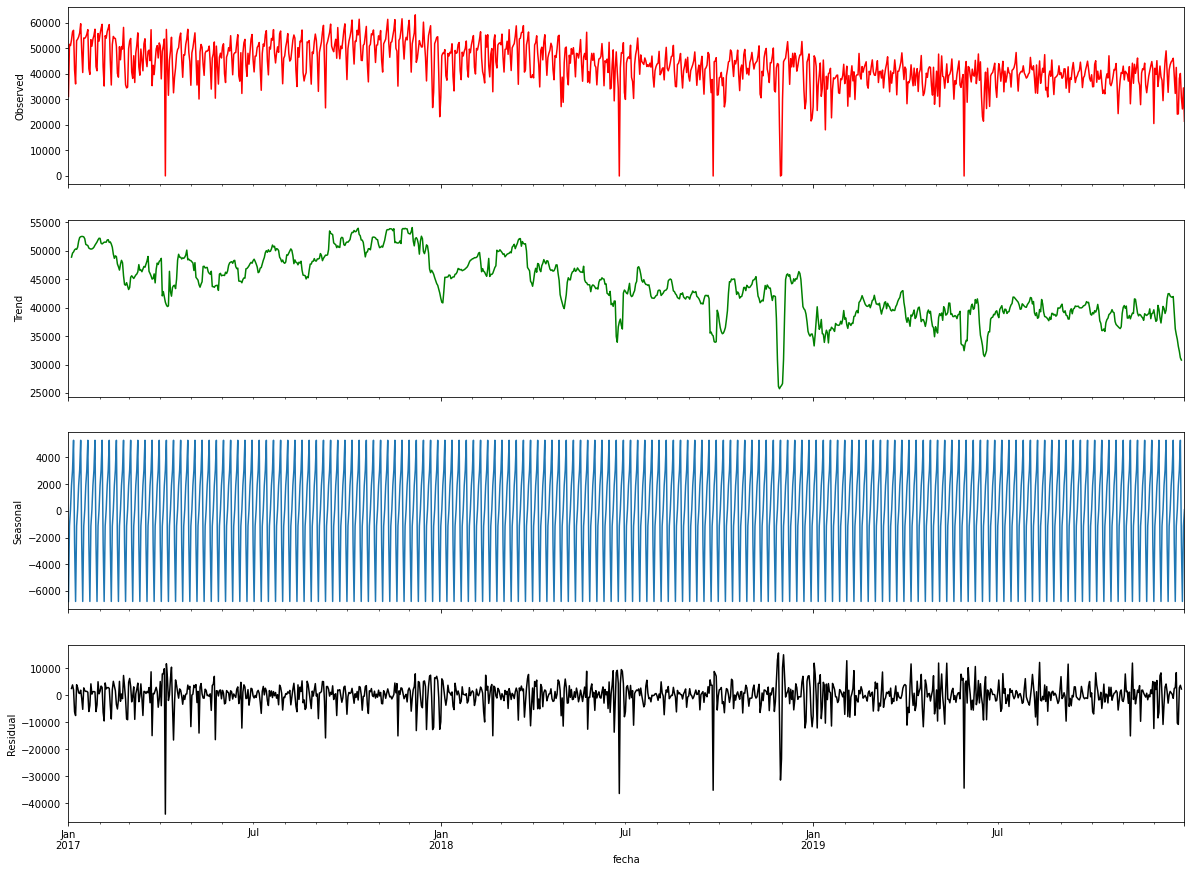

In [28]:
# Se utiliza Seasonal Decompose para obtener componentes de la serie.

result = seasonal_decompose(diario.cantidad_pasos, model='additive', )

fig, axes = plt.subplots(4, 1, sharex=True)

result.observed.plot(ax=axes[0], legend=False, color='r', figsize=(20,15))
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')

* Verificamos que distribución presenta el residual de la serie temporal. En un caso favorable debiera presentar una distribución normal, con centro en 0. Sería un aproximado a la distribución ideal de los residuales. Esto significa que el residual más frecuente sería cercano a cero, lo que es muy favorable.

(array([  1.,   0.,   0.,   1.,   2.,   0.,   1.,   0.,   0.,   0.,   1.,
          0.,   0.,   2.,   5.,   8.,  18.,  18.,  26.,  51.,  88., 213.,
        292., 206.,  86.,  28.,  25.,   8.,   7.,   2.]),
 array([-43992.12068753, -42004.33091342, -40016.5411393 , -38028.75136519,
        -36040.96159107, -34053.17181696, -32065.38204284, -30077.59226873,
        -28089.80249461, -26102.0127205 , -24114.22294638, -22126.43317227,
        -20138.64339815, -18150.85362404, -16163.06384992, -14175.27407581,
        -12187.48430169, -10199.69452758,  -8211.90475346,  -6224.11497935,
         -4236.32520524,  -2248.53543112,   -260.74565701,   1727.04411711,
          3714.83389122,   5702.62366534,   7690.41343945,   9678.20321357,
         11665.99298768,  13653.7827618 ,  15641.57253591]),
 <BarContainer object of 30 artists>)

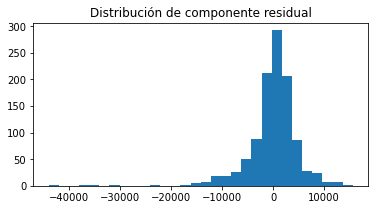

In [29]:
# Gráficamos la distribución del componente residual de la serie. 

plt.figure(figsize=(6,3))
plt.title('Distribución de componente residual')
plt.hist(result.resid, bins=30)

* Distribución del residual: efectivamente presenta una distribución cercana a la normal, pero con un sesgo hacia la izquierda, por lo que esto nos sugiere otra pregunta que podemos realizar al presente trabajo.

* ¿Por qué existe una cola larga sesgada a la izquierda en la distribución del componente residual de la serie de tiempo?

Analizando los datos se puede observar que existen algunos posibles valores atípicos, que hacen que el residual en esos puntos sea negativo y considerablemente grande. 


* Se detectan los días que no se registraron pasos en la estación de peaje (son puntos que no ayudan en lo predictivo al modelo). Existen 4 registros diarios sin pasos en el día.


* Por ejemplo, ¿Qué sucedió el 29 de mayo de 2019 para que no se registren pasos por las cabinas de peaje de Autopista Illia? Ese día se inauguraba una obra que afectaba dicho tramo de la autopista por lo cual es factible que no existiese circulación (https://www.buenosaires.gob.ar/noticias/compromiso-cumplido-inauguramos-el-paseo-del-bajo).


* Ese valor de 0, no consideramos que aporte al modelo por ser un hecho atípico en el funcionamiento diario de la Autopista. Procedemos a imputar los valores iguales a 0 utilizando su media.

In [30]:
# Analizamos la cantidad de días en los que no hubo pasos por dicha cabina.

diario[diario['cantidad_pasos']==0]

,cantidad_pasos
fecha,
2018-06-25,0
2018-09-25,0
2018-11-30,0
2019-05-29,0


## Tratamiento de valores atípicos

In [31]:
# Definimos el modelo que utilizaremos para imputar.

imputer = SimpleImputer(missing_values=0, strategy='mean')

In [32]:
# Imputamos los valores iguales a 0.

diario.cantidad_pasos =imputer.fit_transform(diario['cantidad_pasos'].values.reshape(-1,1))[:,0]

In [33]:
# Ahora, no existen días con pasos igual a 0, sino que fueron reemplazados por su media.

diario[diario['cantidad_pasos']==0]

,cantidad_pasos
fecha,


Text(0, 0.5, 'Residual')

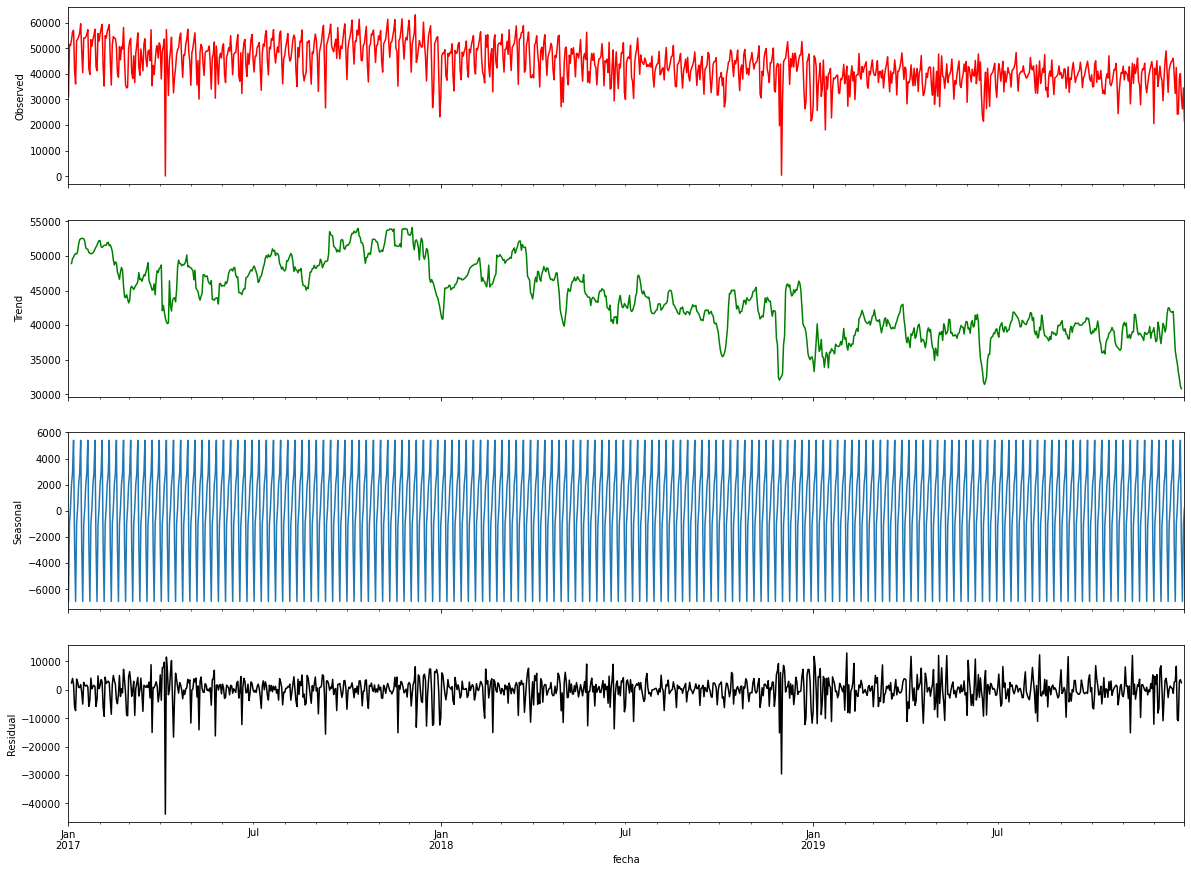

In [34]:
# Analizamos nuevamente los componentes de la serie.

result = seasonal_decompose(diario.cantidad_pasos, model='additive', )

fig, axes = plt.subplots(4, 1, sharex=True)

result.observed.plot(ax=axes[0], legend=False, color='r', figsize=(20,15))
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   3.,   7.,  13.,  15.,  18.,  28.,  49.,  84.,
        208., 287., 219.,  88.,  31.,  22.,   6.,   9.]),
 array([-43831.33920577, -41938.48628728, -40045.63336879, -38152.7804503 ,
        -36259.92753181, -34367.07461332, -32474.22169484, -30581.36877635,
        -28688.51585786, -26795.66293937, -24902.81002088, -23009.95710239,
        -21117.1041839 , -19224.25126541, -17331.39834692, -15438.54542843,
        -13545.69250994, -11652.83959145,  -9759.98667296,  -7867.13375447,
         -5974.28083598,  -4081.42791749,  -2188.574999  ,   -295.72208051,
          1597.13083798,   3489.98375647,   5382.83667495,   7275.68959344,
          9168.54251193,  11061.39543042,  12954.24834891]),
 <BarContainer object of 30 artists>)

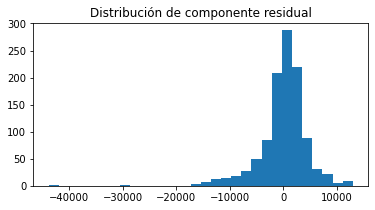

In [35]:
# Y graficamos la distribución de los residuales, para ver como se comportó el sesgo a la izquierda.

plt.figure(figsize=(6,3))
plt.title('Distribución de componente residual')
plt.hist(result.resid, bins=30)

* Si bien aun quedaron un par de días con muy pocos pasos de vehículos en el día, la distribución de los residuales mejoró considerablemente, por lo cual procedemos a utilizar esta información en la continuación del presente proyecto.

**Prueba o rechazo de hipotésis**

* La tendencia negativa que se observa en los datos se debe a la migración del método de pago en efectivo hacia otros métodos.

* Para verificar o rechazar dicha hipotesis, se procede a la incorporación de los otros métodos de pago en el análisis, y se procede nuevamente a graficar la tendencia.

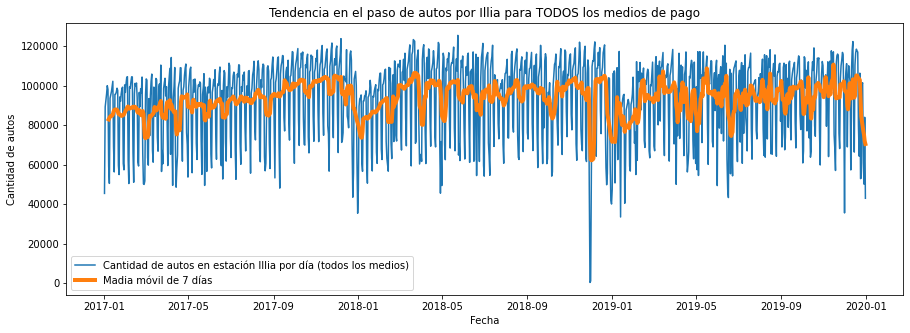

In [36]:
# Analizamos si el método de pago mas frecuente cambió desde el año 2017 a 2019. 
# Para ello utilizamos todos los métodos de pago, y gráficamos nuevamente la tendencia.

dataset_prueba = pd.concat([data_2019, data_2018, data_2017])
dataset_prueba = dataset_prueba[dataset_prueba['estacion']=='Illia']
dataset_prueba.drop(columns = ['periodo','hora_inicio', 'estacion'], inplace = True)
dataset_prueba['fecha2'] = pd.to_datetime(dataset_prueba.fecha) + pd.to_timedelta(dataset_prueba.hora_fin, unit = 'h')
dataset_prueba.drop(columns=['fecha','hora_fin'], inplace = True)
dataset_prueba.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset_prueba.sort_values('fecha', inplace = True)
dataset_prueba.reset_index(drop=True, inplace = True)
diario_prueba = dataset_prueba.resample('D', on = 'fecha').sum()

# Calculamos el promedio de los últimos 7 días (ventana), para generar una media móvil de 7 días:
ventana = 7
diario_promedio_tendencia_otros = diario_prueba.cantidad_pasos.rolling(window=ventana).mean()

# Gráficamos la media móvil obtenida, junto a los datos diarios en Illia para todos los medios de pago:
plt.figure(figsize = (15,5))
plt.plot(diario_prueba.index, diario_prueba.cantidad_pasos, label = 'Cantidad de autos en estación Illia por día (todos los medios)')
plt.plot(diario_promedio_tendencia_otros, lw = 4, label = 'Madia móvil de 7 días')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de autos')
plt.legend()
plt.title('Tendencia en el paso de autos por Illia para TODOS los medios de pago')
plt.show()

* Se verifica la hipótesis de que los usuarios están migrando a otros métodos de pago, no es que haya menos pasos diarios en promedio.

# Predicción a futuro

* A continuación se utilizan varios métodos para realizar las predicciones de pasos diarios por Autopista Illia y con pago en efectivo.

## Método 1: RandomForestRegressor

* Se entrena un `RandomForestRegressor` para predecir el siguiente valor en la serie de tiempo diaria de pasos por la estación de peaje Illia para pago en efectivo. Se utilizarán los primeros 915 días como conjunto de entrenamiento. Y 180 días como evaluación. Para ello, hay que realizar unos ajustes sobre los datos.

In [37]:
# Creamos un conjunto de datos que sólo considere la cantidad de pasos diarios, y lo llamamos senial.
senial = diario.cantidad_pasos
look_back = 365 #Decidimos utilizar un año de información para predecir hacia adelante.

N = senial.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)

for i in range(X.shape[0]):
#     X[i,:] = senial.values.iloc[i:i+look_back]
#     y[i] = senial.values.iloc[i+look_back]
    X[i,:] = senial.iloc[i:i+look_back]
    y[i] = senial.iloc[i+look_back]


N_train = 915 - look_back     #Cantidad de instancias que vamos a utilizar para entrenar. 
N_test = 180                  #Cantidad de puntos que vamos a utilizar para evaluar.
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]       #Definimos los conjuntos de entrenamiento.
y_train = y[:N_train]

X_test = X[N_train:N_train+N_test,:]  #Definimos los conjuntos de testeo.
y_test = y[N_train:N_train+N_test]

# Instanciamos un modelo Random Forest y lo entrenamos sobre conjuntos de entrenamiento.
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = 4).fit(X_train,y_train)

In [38]:
# Generamos las predicciones sobre los conjuntos de entrenamiento y prueba.
y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

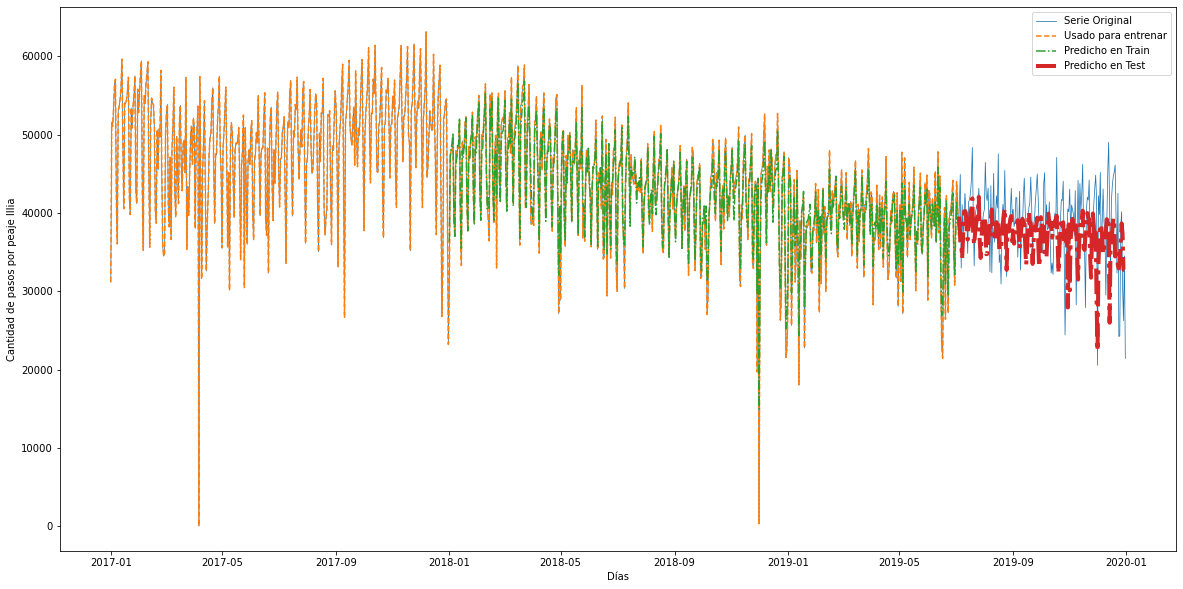

In [39]:
# Graficamos los resultados obtenidos de las predicciones, sobre los registros reales disponibles.
plt.figure(figsize=(20,10))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total-1], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Días')
plt.ylabel('Cantidad de pasos por peaje Illia')
plt.show()

### Evaluación de modelo 1

* Se decide utilizar como medida de evaluación de este modelo Raíz del Error Cuadrático Medio.
* Se utiliza esta medida en particular ya que como principal ventaja vemos que mantiene la magnitud de los datos de entrada, lo que nos simplificará la comparativa a futuro con otros modelos.
* Se obtiene un error de 4.947 pasos por día de media en el conjunto de testeo. Por otro lado, en el conjunto de entrenamiento el error fue bastante inferior, alcanzando una magnitud de 1.923 pasos por día.

In [40]:
MSE = mean_squared_error(y_train, y_train_pred)
print('Error en Train:',np.sqrt(MSE))
MSE = mean_squared_error(y_test, y_test_pred)
print('Error en Test:',np.sqrt(MSE))

Error en Train: 1923.117869879487
Error en Test: 4947.550874712359


### ¿Qué información esta utilizando el modelo de Random Forest para predecir?

* El modelo presenta un patrón cíclico en la importancia que le da a las 365 variables predictoras que definimos en el modelo. Esto lo podemos ver como "picos" en el gráfico del peso de las variables en el modelo de Random Forest.
* Como era de esperar en un conjunto de datos cíclicos, la importancia predictora de cada uno de los días debe ser de algún patrón cíclico. Justamente esto es lo que se observa en el gráfico de más abajo.

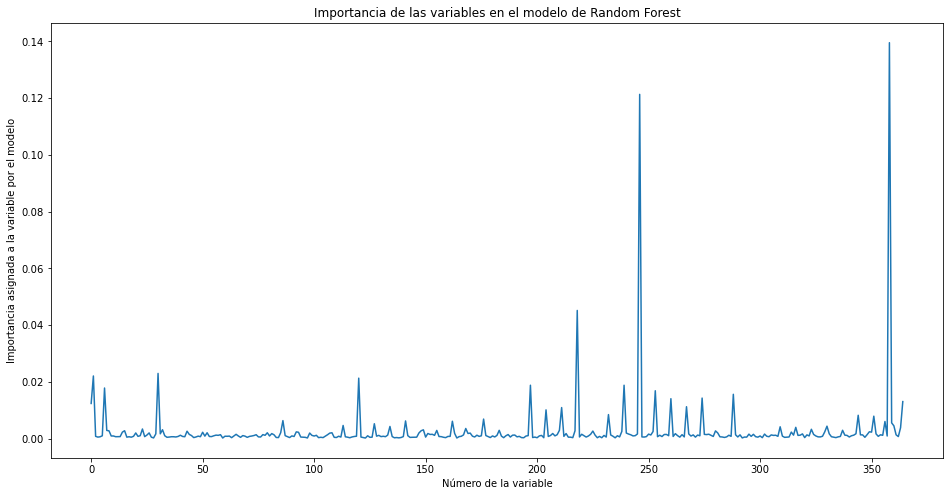

In [41]:
plt.figure(figsize=(16,8))
plt.title('Importancia de las variables en el modelo de Random Forest')
plt.xlabel('Número de la variable')
plt.ylabel('Importancia asignada a la variable por el modelo')
plt.plot(rf.feature_importances_)

## Método 2: Benchmark

* Se considera como predicción de un día, la misma cantidad de pasos que el día previo.

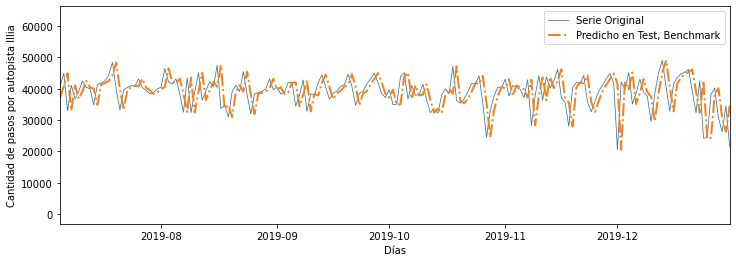

In [42]:
# Se realizan las predicciones copiando el dato de la fecha previa.
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]

# Se grafican los resultados obtenidos.
plt.figure(figsize=(12,4))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred_benchmark,'-.', lw = 2, label = 'Predicho en Test, Benchmark')
plt.xlim(senial.index[N_train+look_back], senial.index[length_total-1])
plt.xlabel('Días')
plt.ylabel('Cantidad de pasos por autopista Illia')
plt.legend()
plt.show()

### Evaluación de modelo 2

* Se decide utilizar como medida de evaluación de este modelo Raíz del Error Cuadrático Medio.
* Se utiliza esta medida en particular ya que como principal ventaja vemos que mantiene la magnitud de los datos de entrada, lo que nos simplificará la comparativa a futuro con otros modelos.
* El error de este modelo simple de bench, es de 5.928 pasos por día en el conjunto de testeo.

In [43]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]
MSE = mean_squared_error(y_test, y_test_pred_benchmark[0:179])
print(np.sqrt(MSE))

5928.70507072518


## Método 3: ARIMA model

En estadística y econometría, en particular en series temporales, un modelo autorregresivo integrado de promedio móvil o ARIMA (acrónimo del inglés autoregressive integrated moving average) es un modelo estadístico que utiliza variaciones y regresiones de datos estadísticos con el fin de encontrar patrones para una predicción hacia el futuro. Se trata de un modelo dinámico de series temporales, es decir, las estimaciones futuras vienen explicadas por los datos del pasado y no por variables independientes.

Fue desarrollado a finales de los sesenta del siglo XX. Box y Jenkins (1976) lo sistematizaron.

Fuente: Wikipedia.

Previo a poder realizar las predicciones en cuestión se requiere que la serie de tiempo sea estacionaria (requisito del modelo), lo que significa que no debe tener una tendencia evidente en el tiempo, y una varianza bastante constante.

In [44]:
# Utilizamos el test de Adfuller, y mediante el valor p-value obtenido determinar cuando la serie es estacionaria.
# Se define una función para la realización del test, ya que será nuevamente utilizada a futuro.

def adfuller_test(PasosDiarios):
    result=adfuller(PasosDiarios)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used', 'Critical Values']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is Stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is Non-Stationary ")

In [80]:
# Aplicamos el método Adfuller sobre la variable diario, para averiguar si es estacionaria.

adfuller_test(diario['cantidad_pasos'])

ADF Test Statistic : -1.869951291428352
p-value : 0.3463262806195344
#Lags Used : 20
Number of Observations Used : 1067
Critical Values : {'1%': -3.4364934880312177, '5%': -2.8642525616723336, '10%': -2.568214266743025}
Weak evidence against null hypothesis, time series has a unit root, indicating it is Non-Stationary 


* Como la serie NO es estacionaria, debemos aplicar transformaciones sobre la misma para que sea ESTACIONARIA.

* Se genera una nueva columna que es la diferencia entre la actual y una desplazada en 7 días (estimo que puede ser un ciclo, por análisis de los datos realizados en el preprocesamiento). 

* Ademas podemos utilizar otros estadísticos para ver la confianza del resultado (Si el estadístico general está por debajo del estadístico 1%, significa que la confianza es mayor al 99%)

In [81]:
# Para desplazar los datos en siete periodos se utiliza la función shift.

diario['cant_pasos_dif'] = diario['cantidad_pasos'] - diario['cantidad_pasos'].shift(7)
diario.head(2)

,cantidad_pasos,cant_pasos_dif
fecha,,
2017-01-08,36065.0,NaN
2017-01-09,53036.0,NaN


In [82]:
# Como se desplazaron los datos en siete periodos, claramente los primeros seis valores de esa columna serán faltantes.
# Se procede a eliminar dichas filas del DataFrame.test_data

diario.dropna(inplace=True)
diario.head()

,cantidad_pasos,cant_pasos_dif
fecha,,
2017-01-15,40546.0,4481.0
2017-01-16,54061.0,1025.0
2017-01-17,53940.0,339.0
2017-01-18,54468.0,-55.0
2017-01-19,55548.0,-494.0


In [83]:
# Aplico el Adfuller Test a esta nueva columna generada, para verificar si la serie ahora es estacionaria.

adfuller_test(diario['cant_pasos_dif'])

ADF Test Statistic : -9.46315921287334
p-value : 4.2995002205460584e-16
#Lags Used : 21
Number of Observations Used : 1059
Critical Values : {'1%': -3.436540010983293, '5%': -2.8642730819775406, '10%': -2.5682251959417948}
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is Stationary


* Como p-value es claramente menor a 0.05, podemos rechazar la hipotesis de nulidad, y afirmar que la serie es estacionaria.
* Como el indicador del Test Statistic es menor al valor crítico de 1%, podemos afirmar que tenemos una confiabilidad mayor al 99%.

<AxesSubplot:xlabel='fecha'>

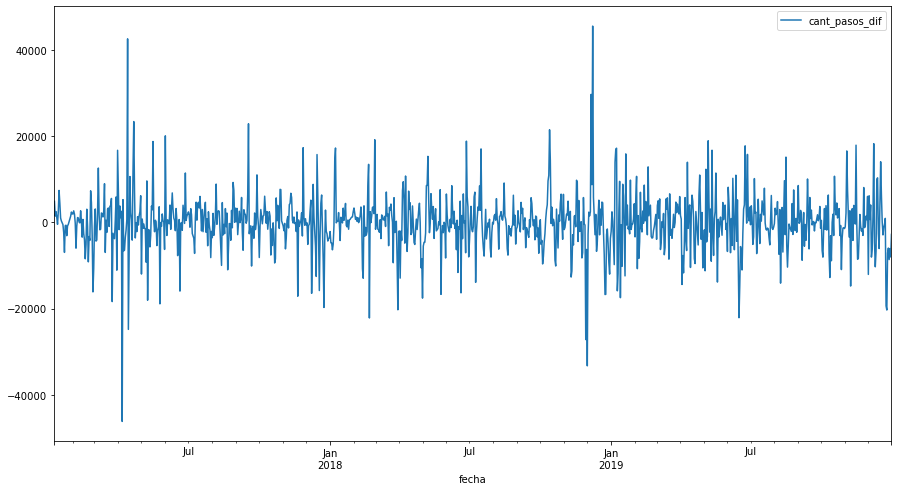

In [49]:
# Verificamos gráficamente la NO existencia de tendencia en la nueva serie de tiempo, y la estacionariedad en cuestión.

diario[['cant_pasos_dif']].plot(figsize=(15,8))

#### Oportunidades de mejora detectadas a futuro

* Detectamos unos cuatro puntos en la nueva serie sobre los cuales podríamos seguir trabajando en una nueva iteración del proyecto (en el preprocesamiento de los datos). Más precisamente hablamos de trabajar sobre outliers distintos a ceros, que fueron los que imputamos por ahora. 

In [84]:
# Seleccionamos solo la columna que es estacionaria, para poder implementar ARIMA.

diario_arima = diario.drop(columns='cantidad_pasos')
diario_arima.head()

,cant_pasos_dif
fecha,
2017-01-15,4481.0
2017-01-16,1025.0
2017-01-17,339.0
2017-01-18,-55.0
2017-01-19,-494.0


Figure(432x288)


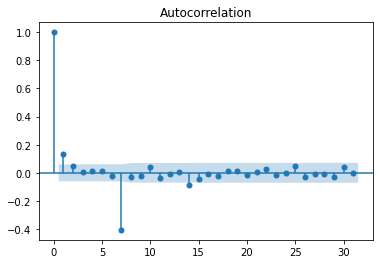

In [86]:
# En primer lugar graficamos el componente de autocorrelación, para a partir del mismo identificar el hiperparámetro p del modelo ARIMA.

print(plot_acf(diario_arima['cant_pasos_dif']))

* Como valores adecuados para p, podríamos indicar 2, ya que es el primer valor que se encuentra en la zona recomendada de Autocorrelation.

Figure(432x288)


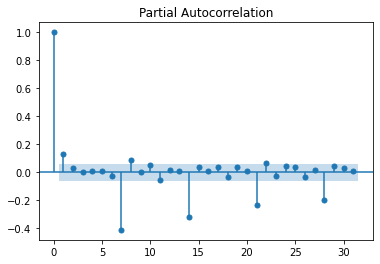

In [87]:
# Autocorrelación parcial:

print(plot_pacf(diario_arima['cant_pasos_dif']))

* De acuerdo al gráfico de PACF, de autocorrelación parcial, los posibles mejores valores para q serían en orden de prueba: 2 o 3.

                              ARMA Model Results                              
Dep. Variable:         cant_pasos_dif   No. Observations:                 1081
Model:                     ARMA(2, 2)   Log Likelihood              -10953.653
Method:                       css-mle   S.D. of innovations           6072.556
Date:                Sun, 01 Aug 2021   AIC                          21919.307
Time:                        11:00:57   BIC                          21949.220
Sample:                    01-15-2017   HQIC                         21930.633
                         - 12-31-2019                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -136.0996    220.040     -0.619      0.536    -567.371     295.171
ar.L1.cant_pasos_dif    -1.5017      0.024    -62.332      0.000      -1.549      -1.455
ar.L2.cant_p

Text(0.5, 1.0, 'ARIMA Model')

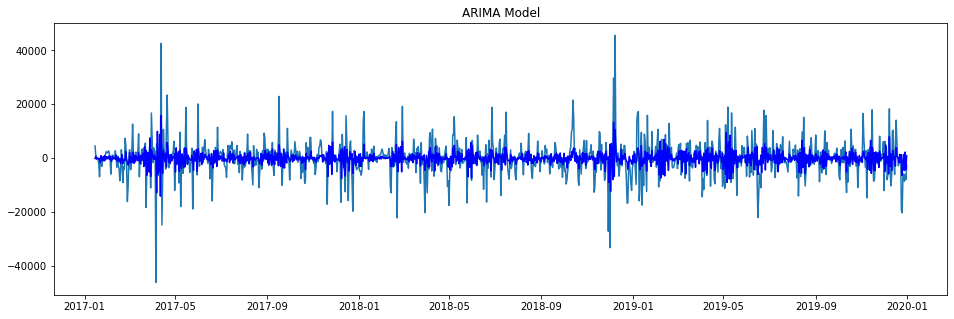

In [88]:
# Instanciamos el modelo ARIMA y lo entrenamos, para posteriormente imprimir los resultados en pantalla.

model_arima = ARIMA(diario_arima, order=(2,0,2))
results_arima = model_arima.fit()
print(results_arima.summary())

plt.figure(figsize=(16,5))
plt.plot(diario_arima)
plt.plot(results_arima.fittedvalues, color='blue')
plt.title('ARIMA Model')

In [89]:
# Se separan los datos en conjuntos de entrenamiento y prueba.

training_data=diario_arima[0:915]
test_data=diario_arima[915:]

In [90]:
# Se generan las predicciones para la cantidad de periodos del conjunto de testeo:

predictions=results_arima.forecast(steps=len(test_data))[0]

In [91]:
# Evaluamos el error en las predicciones

np.sqrt(mean_squared_error(test_data,predictions))

6019.420186313027

* La raíz del error cuadrático medio sobre el conjunto de testeo es de 6019 pasos diarios (recordar que esta no es la variable original)

* A continuación se devuelve la variable a la dimensión original. Al final se calcula nuevamente el Error Cuadrático Medio para verificar que la transformación inversa se realizo de manera correcta. Por una cuestión matemática el RMSE debe ser el mismo.

In [99]:
resultado_var_original = diario[915:]
resultado_var_original.head()

,cantidad_pasos,cant_pasos_dif
fecha,,
2019-07-19,48381.0,7943.0
2019-07-20,39900.0,-121.0
2019-07-21,33247.0,-1595.0
2019-07-22,39618.0,-1783.0
2019-07-23,40445.0,-1308.0


In [100]:
resultado_var_original['Shift7'] = resultado_var_original['cantidad_pasos']-resultado_var_original['cant_pasos_dif']
resultado_var_original.head()

,cantidad_pasos,cant_pasos_dif,Shift7
fecha,,,
2019-07-19,48381.0,7943.0,40438.0
2019-07-20,39900.0,-121.0,40021.0
2019-07-21,33247.0,-1595.0,34842.0
2019-07-22,39618.0,-1783.0,41401.0
2019-07-23,40445.0,-1308.0,41753.0


In [101]:
resultado_var_original['predictions'] = predictions
resultado_var_original.head()

,cantidad_pasos,cant_pasos_dif,Shift7,predictions
fecha,,,,
2019-07-19,48381.0,7943.0,40438.0,-1036.476400
2019-07-20,39900.0,-121.0,40021.0,-623.071977
2019-07-21,33247.0,-1595.0,34842.0,1206.901232
2019-07-22,39618.0,-1783.0,41401.0,-1822.068293
2019-07-23,40445.0,-1308.0,41753.0,1483.335727


In [102]:
resultado_var_original['pred_var_original'] = resultado_var_original['predictions'] + resultado_var_original['Shift7']
resultado_var_original.head()

,cantidad_pasos,cant_pasos_dif,Shift7,predictions,pred_var_original
fecha,,,,,
2019-07-19,48381.0,7943.0,40438.0,-1036.476400,39401.523600
2019-07-20,39900.0,-121.0,40021.0,-623.071977,39397.928023
2019-07-21,33247.0,-1595.0,34842.0,1206.901232,36048.901232
2019-07-22,39618.0,-1783.0,41401.0,-1822.068293,39578.931707
2019-07-23,40445.0,-1308.0,41753.0,1483.335727,43236.335727


In [103]:
np.sqrt(mean_squared_error(resultado_var_original['cantidad_pasos'],resultado_var_original['pred_var_original']))

6019.420186313027

* Se grafican los resultados obtenidos con ARIMA model vs los valores reales de pasos por día.

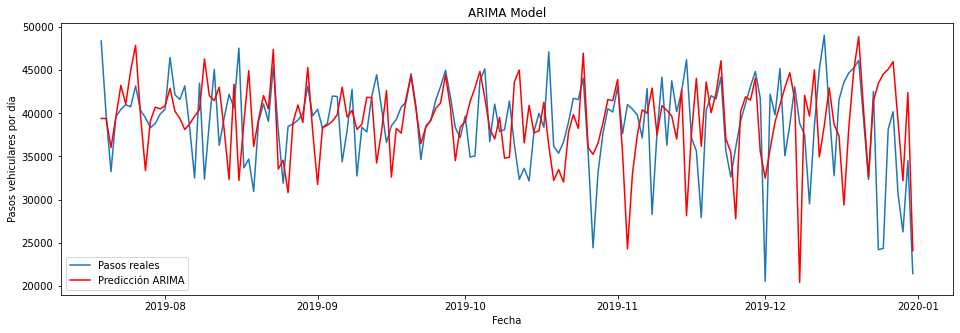

In [130]:
plt.figure(figsize=(16,5))
plt.plot(resultado_var_original['cantidad_pasos'], label='Pasos reales')
plt.plot(resultado_var_original['pred_var_original'], color='red', label='Predicción ARIMA')
plt.title('ARIMA Model')
plt.xlabel('Fecha')
plt.ylabel('Pasos vehiculares por día')
plt.legend()
plt.show()

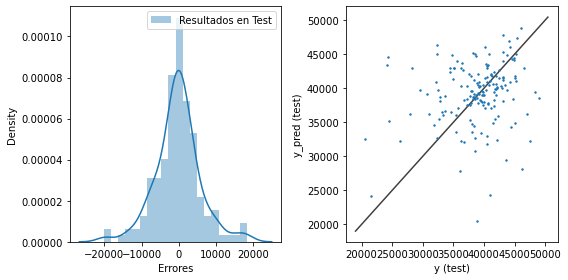

In [104]:
# Análisis de la distribución de los errores.

plt.figure(figsize = (8,4))

plt.subplot(1,2,1)
sns.distplot(resultado_var_original['cantidad_pasos'] - resultado_var_original['pred_var_original'], bins = 20, label = 'Resultados en Test')
plt.xlabel('Errores')
plt.legend()

ax = plt.subplot(1,2,2)
ax.scatter(resultado_var_original['cantidad_pasos'],resultado_var_original['pred_var_original'], s =2)    
lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
]
    
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')
    
plt.tight_layout()
plt.show()

#### Conclusiones con respecto a la distribución de los errores en conjunto de testeo

* Más allá del resultado de la raíz del error cuadrático medio que obtuvimos en el punto anterior, es sumamente importante ver en que rangos de valores se distribuyen los errores en el conjunto de testeo.
* Como podemos ver en los gráficos anteriores, los errores están distribuidos con centro en 0 y presentan una distribución similar a normal. Esto quiere decir, que si bien el modelo está presentando un cierto nivel de error, existen muchas predicciones que tienen un error cercano a 0, lo que es una situación más que favorable.
* Si nos centramos sólamente en el resultado obtenido del modelo evaluado mediante RMSE, se puede afirmar que utilizando ARIMA no se logró mejorar la eficiencia en las predicciones obtenidas mediante Random Forest.

### Adicional Método 4: Optimización de hiperparámetros para implementación de ARIMA

* A continuación se postula una manera de implementar una optimización de hiperparámetros para p, d, q, SIN la utilización del modelo de AUTO ARIMA.

In [57]:
#p_values=range(0,2)
#q_values=range(0,2)
#d_values=range(0,1)

#for p in p_values:
#    for d in d_values:
#        for q in q_values:
#            order=(p,d,q)
#            train=diario_arima[0:900]
#            test=diario_arima[900:]
#            predictions=[]
#            for i in range(len(test)):
#                try:
#                    arima=ARIMA(train,order)
#                    model=arima.fit(disp=0)
#                    pred=model.forecast()[0]
#                    predictions.append(pred)
#                    error=mean_squared_error(test,predictions)
#                    print('MSE is {} with order {}'.format(error,order))
#                except:
#                    continue

MSE is 35056914.0756 with order (0, 0, 0)
MSE is 35051039.55713347 with order (0, 0, 1)
MSE is 35055782.63478771 with order (1, 0, 0)
MSE is 35220109.51167875 with order (1, 0, 1)


* Por una cuestión de optimización de recursos computacionales, en el presente proyecto se comentó el código necesario, ya que la ganancia en la mejora del RMSE no justifica el tiempo requerido para llevarlo a cabo de una manera adecuada. Igualmente se dejó el código impreso en pantalla para alguna implementación o mejora futura.
* La optimización de hiperparámetros se tuvo en cuenta al momento de seleccionar p=2 y q=2 en el modelo ARIMA entrenado anteriormente.

## Utilización del modelo para predicciones sobre año 2020

* En primer lugar debemos cargar el dataset del año 2020.
* En segundo término generar predicciones en 365 ubicaciones adicionales.
* Verificar nuevamente el error RMSE para evaluar que tan bien se comporta el modelo.

In [107]:
data_2020 = pd.read_csv(r'C:\Users\GASTON\Desktop\Proyecto 3\flujo-vehicular-2020.csv', sep =',')
data_2020.head()

,periodo,fecha,mes,dia,dia_fecha,hora_inicio,hora_fin,estacion,tipo_vehiculo,forma_pago,observacion,sentido,cantidad_pasos
0,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Efectivo,Efectivo,Centro,24.0
1,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Efectivo,Efectivo,Provincia,80.0
2,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Rec.Deuda,Paso en Infracción,Provincia,1.0
3,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Rec.Deuda,Paso en infracción con Multa LPR,Centro,1.0
4,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Rec.Deuda,Paso en infracción con Multa LPR,Provincia,1.0


In [110]:
print(data_2020['estacion'].unique())

['ALBERDI' 'AVELLANEDA' 'DELLEPIANE LINIERSLEPIANE CENTRO'
 'DELLEPIANE LINIERS' 'ILLIA' 'ILP' 'PB1' 'PB3' 'PB4' 'RETIRO' 'SALGUERO'
 'SARMIENTO' 'PB2']


In [111]:
#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask_2020 = np.logical_and(data_2020.estacion=='ILLIA', data_2020.forma_pago == 'Efectivo')
data_2020 = data_2020[mask_2020]
#Quitamos las columnas que no vamos a utilizar
data_2020.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)
data_2020.head()

,fecha,mes,dia,dia_fecha,hora_fin,tipo_vehiculo,observacion,sentido,cantidad_pasos
52,2020-01-01 00:00:00,enero,Miércoles,1.0,1.0,Auto,Efectivo,Centro,326.0
53,2020-01-01 00:00:00,enero,Miércoles,1.0,1.0,Auto,Efectivo,Provincia,319.0
134,2020-01-01 00:00:00,enero,Miércoles,1.0,2.0,Auto,Efectivo,Centro,199.0
135,2020-01-01 00:00:00,enero,Miércoles,1.0,2.0,Auto,Efectivo,Provincia,180.0
202,2020-01-01 00:00:00,enero,Miércoles,1.0,3.0,Auto,Efectivo,Centro,114.0


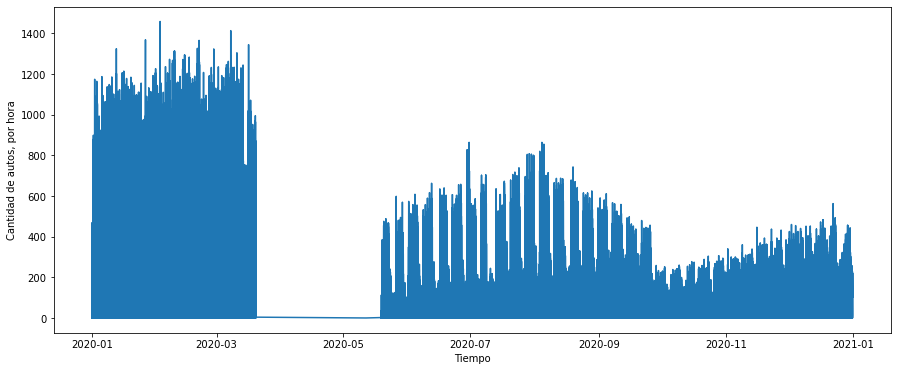

In [112]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
data_2020['fecha2'] = pd.to_datetime(data_2020.fecha) + pd.to_timedelta(data_2020.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
data_2020.drop(columns=['fecha','hora_fin'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
data_2020.rename(columns = {'fecha2':'fecha'}, inplace = True) 

#Reordenamos el dataset por fecha
data_2020.sort_values('fecha', inplace = True)
data_2020.reset_index(drop=True, inplace = True)

#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(data_2020.fecha, data_2020.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

#### Primeras conclusiones del tráfico por autopista Illia en 2020

* Se observa un primer trimestre en línea a los pasos por hora de fines de 2019.
* En marzo de 2020 se eliminan los pasos por hora en autopista Illia, entonces sólo del análisis de los datos nos podríamos preguntar que sucedió en marzo de 2020. Buscando dicha información se confirma que en marzo de 2020 se declara una cuarentena estricta en Argentina, por lo cual no se estuvo abonando peajes, con casi nula circulación. Los datos sólo confirmar la realidad.

In [114]:
# Resampleamos los pasos por hora a pasos por día.

diario_2020 = data_2020.resample('D', on = 'fecha').sum()
diario_2020.drop(columns='dia_fecha', inplace=True)
print(diario_2020.shape)
diario_2020.head()

(366, 2)


,dia_fecha,cantidad_pasos
fecha,,
2020-01-01,184.0,21395.0
2020-01-02,408.0,33722.0
2020-01-03,618.0,37067.0
2020-01-04,824.0,30627.0
2020-01-05,1085.0,27812.0


In [117]:
diario_2020.head()

,cantidad_pasos
fecha,
2020-01-01,21395.0
2020-01-02,33722.0
2020-01-03,37067.0
2020-01-04,30627.0
2020-01-05,27812.0


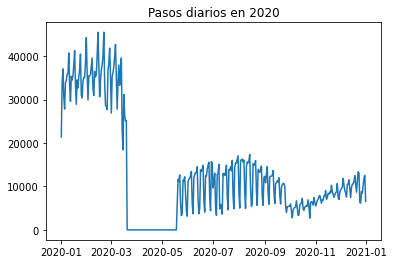

In [135]:
# Se grafican los pasos diarios en 2020
plt.plot(diario_2020['cantidad_pasos'])
plt.title('Pasos diarios en 2020')
plt.show()

### Generamos predicciones con ARIMA model para el año 2020

In [132]:
# Se generan las predicciones para la cantidad de periodos del conjunto de testeo:

predictions_2020 = results_arima.forecast(steps=365+len(test_data))[0]
predictions_2020.shape

(531,)

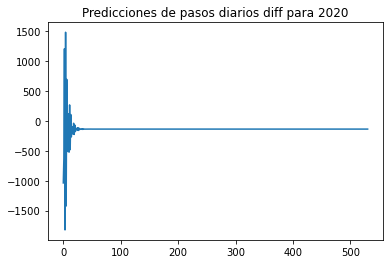

In [137]:
plt.title('Predicciones de pasos diarios diff para 2020')
plt.plot(predictions_2020)

#### Conclusiones de las predicciones con ARIMA para 2020

* Recordar que la predicción es sobre la diferencia de 7 días en los pasos por la cabina Illia.

* En primer lugar no consideramos pertinente utilizar los datos de 2017, 2018, 2019 para predecir 2020. Esto sucede, ya que como vimos en los gráficos anteriores de exploración de la pregunta, vemos que 2020 es un año atípico que nada tuvo que ver con los años precedentes, por lo cual la información pasada no se puede utilizar para predecir el futuro (en este caso 2020).

* Otro inconveniente que vemos es la imposibilidad de utilizar aproximadamente 2,5 años de datos de entrenamiento para intentar predecir casi 1,5 años hacia delante. Esto genera otro sesgo en la poca información que tenemos de los días más cercanos a 2020. 

* Una aproximación para solucionar esto, sería utilizar periodos muy cortos de tiempo del mismo año 2020, para predecir días siguientes, pero nunca utilizar el modelo entrenado con los años 2017 a 2019 para la predicción de 2020.

## Conclusiones Proyecto 3 e introducción al Proyecto 4

1. Los métodos utilizados en el presente proyecto nos permitieron predecir los pasos diarios a futuro con una cierta eficacia, pero detectamos algunas mejoras o limitaciones en dichos algoritmos. 
2. La principal limitación de estos modelos o métodos tradicionales de Series de Tiempo está en que se centran en una ciclicidad semanal SOLAMENTE y no son capaces de predecir teniendo en cuenta dos tipos de ciclicidades, SEMANALES Y MENSUALES  al mismo tiempo. Una manera de subsanar esto sería crear un modelo tradicional, estilo Random Forest, que considere los días de la semana como variables (pero nos estaríamos olvidando de la serie de tiempo). Además para responder una de las preguntas objetivo del trabajo, podríamos incluir en esas variables otras condiciones como el tipo de vehículo por ejemplo. Pero sería un modelo totalmente distinto a los generados en este proyecto, y que redundarían en una extensión considerable del mismo.
3. Para el caso de negocio de pasos diarios por una cabina de peaje, tal vimos en el desarrollo del proyecto, existen dos tipos de ciclicidades evidentes: una relacionada al día de la semana y otra al mes del año. 
4. Teniendo en cuenta los puntos anteriores consideramos introducir un nuevo método para la realización del Proyecto 4, que logre subsanar esta limitación la cual se considera muy importante.
5. En el Proyecto 4 se trabajarán las predicciones utilizando PROPHET el cual además de la ventaja ya mencionada también nos permite realizar predicciones más rápidas, es más sencillo al momento de realizar validaciones cruzadas, se obtienen gráficos muy interesantes respecto a los cambios de tendencia en la serie de tiempo, no es afectado en caso de haber NA en la serie y una ventaja sumamente importante adicional: no es necesario que las fechas estén equidistantes entre ellas.
6. Otra ventaja adicional: es de uso libre.

# Proyecto 4

* Para el presente proyecto se definen ejecutar cuatro pasos fundamentales.

1) Se realizan los ajustes y modificaciones sugeridos por el evaluador durante el proyecto 3.
2) Realizamos un proceso predictivo de punta a punta, utilizando una librería y algoritmos que no vimos en las clases: Prophet. Se realizan predicciones acerca de 2020.
3) Realizamos una nueva pregunta que se podría responder o no con la información que tenemos al momento.
4) Se propone cómo continuar con el proyecto para que sea realmente superador al actual, y seguramente con un mejor nivel de eficacia en las predicciones. 

In [58]:
# Se importan las librerías necesarias para el trabajo.

import fbprophet
from fbprophet import Prophet

In [59]:
# Realizamos una verificación para asegurarnos de tener todos los módulos necesarios.

dir(Prophet)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_load_stan_backend',
 'add_country_holidays',
 'add_group_component',
 'add_regressor',
 'add_seasonality',
 'construct_holiday_dataframe',
 'fit',
 'flat_growth_init',
 'flat_trend',
 'fourier_series',
 'initialize_scales',
 'linear_growth_init',
 'logistic_growth_init',
 'make_all_seasonality_features',
 'make_future_dataframe',
 'make_holiday_features',
 'make_seasonality_features',
 'parse_seasonality_args',
 'percentile',
 'piecewise_linear',
 'piecewise_logistic',
 'plot',
 'plot_components',
 'predict',
 'predict_seasonal_components',
 'predict_trend',
 'predict_uncertainty',
 'predictive_samples',
 'regressor_col

In [60]:
# Vamos a continuar trabajando con el DataFrame "diario", que contine los pasos diarios por la autopista Illia y con pago en efectivo.

diario.head()

,cantidad_pasos,cant_pasos_dif
fecha,,
2017-01-08,36065.0,4882.0
2017-01-09,53036.0,1468.0
2017-01-10,53601.0,2508.0
2017-01-11,54523.0,1191.0
2017-01-12,56042.0,-444.0


In [61]:
# Se procede a crear un modelo mediante Prophet con el cual se realizarán las predicciones.

m = Prophet()

In [62]:
# Uno de los requerimientos de Prophet es que las columnas se llamen: "ds" para la fecha e "y" para la variable a predecir, en este caso los pasos diarios.
# A este nuevo DataFrame lo llamaremos "df_prophet".

df_prophet = diario.rename_axis('ds').reset_index()
df_prophet = df_prophet.rename(columns={'cantidad_pasos':'y'})
df_prophet.head()

,ds,y,cant_pasos_dif
0,2017-01-08,36065.0,4882.0
1,2017-01-09,53036.0,1468.0
2,2017-01-10,53601.0,2508.0
3,2017-01-11,54523.0,1191.0
4,2017-01-12,56042.0,-444.0


In [63]:
# En segundo lugar, se entrena el modelo creado, utilizando el modelo m y el DataFrame "diario".
# A este nuevo modelo entrenado se lo llamará "model".

model = m.fit(df_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [64]:
# Se analizan los parámetros de Prophet.

model.seasonalities

OrderedDict([('yearly',
              {'period': 365.25,
               'fourier_order': 10,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None}),
             ('weekly',
              {'period': 7,
               'fourier_order': 3,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None})])

In [65]:
df_prophet.tail()

,ds,y,cant_pasos_dif
1083,2019-12-27,40182.0,-5946.0
1084,2019-12-28,30681.0,-8622.0
1085,2019-12-29,26259.0,-6078.0
1086,2019-12-30,34523.0,-8008.0
1087,2019-12-31,21447.0,-2773.0


In [66]:
# Para poder realizar las predicciones con Prophet, es necesario generar una cierta cantidad de días futuros sobre los cuales realizar las mismas.
dias_futuro = model.make_future_dataframe(periods=180,freq='D')

In [67]:
# Estos nuevos días generado, se agregan al DataFrame que ya teníamos. En este caso contabamos con los años completos 2017, 2018 y 2019.
# Ahora generamos 30 días nuevos, del año 2020.

dias_futuro

,ds
0,2017-01-08
1,2017-01-09
2,2017-01-10
3,2017-01-11
4,2017-01-12
...,...
1263,2020-06-24
1264,2020-06-25
1265,2020-06-26
1266,2020-06-27


In [68]:
# Se realizan las predicciones sobre los días futuros.

prediction = model.predict(dias_futuro)
prediction.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1263,2020-06-24,35748.503325,28644.752451,41316.870021,35050.842200,36411.260427,-335.522108,-335.522108,-335.522108,2033.888378,2033.888378,2033.888378,-2369.410486,-2369.410486,-2369.410486,0.0,0.0,0.0,35412.981217
1264,2020-06-25,35740.307570,30179.408034,42549.258823,35038.131137,36413.910862,601.165527,601.165527,601.165527,2879.740431,2879.740431,2879.740431,-2278.574904,-2278.574904,-2278.574904,0.0,0.0,0.0,36341.473097
1265,2020-06-26,35732.111815,32655.757369,45609.486581,35027.895723,36413.614667,3231.928037,3231.928037,3231.928037,5395.324161,5395.324161,5395.324161,-2163.396124,-2163.396124,-2163.396124,0.0,0.0,0.0,38964.039852
1266,2020-06-27,35723.916061,24428.749166,37851.696135,35012.016718,36413.351703,-4578.537351,-4578.537351,-4578.537351,-2553.611300,-2553.611300,-2553.611300,-2024.926051,-2024.926051,-2024.926051,0.0,0.0,0.0,31145.378709
1267,2020-06-28,35715.720306,20227.488356,33321.473638,34998.313409,36413.131830,-8776.806655,-8776.806655,-8776.806655,-6912.127088,-6912.127088,-6912.127088,-1864.679567,-1864.679567,-1864.679567,0.0,0.0,0.0,26938.913651


In [69]:
# Imprimimos sólo aquellas columnas que más información arrojan de la salida de Prophet.

prediction[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1263,2020-06-24,35412.981217,28644.752451,41316.870021
1264,2020-06-25,36341.473097,30179.408034,42549.258823
1265,2020-06-26,38964.039852,32655.757369,45609.486581
1266,2020-06-27,31145.378709,24428.749166,37851.696135
1267,2020-06-28,26938.913651,20227.488356,33321.473638


Figure(720x432)


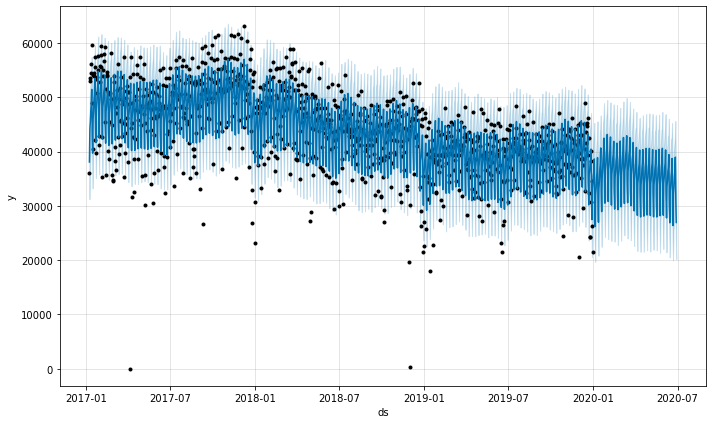

In [70]:
# Se imprimen las predicciones en pantalla.

print(model.plot(prediction))

Figure(648x648)


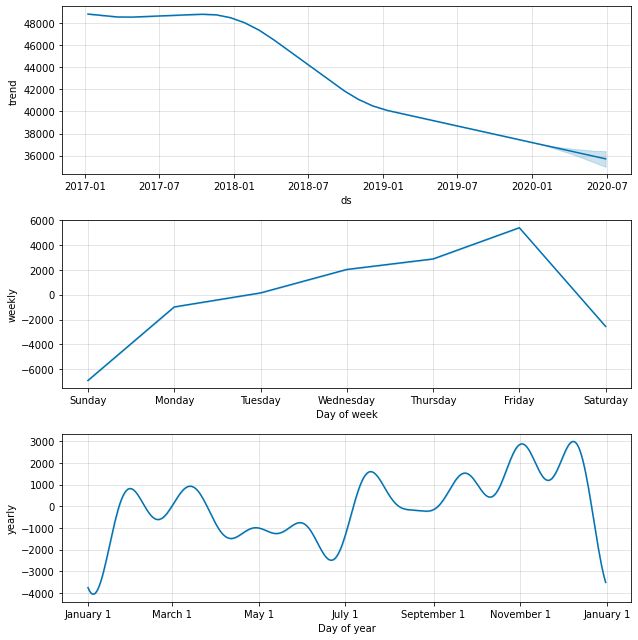

In [71]:
# Graficamos los componentes de la serie de tiempo mediante Prophet.

print(model.plot_components(prediction))

## Ventajas asociadas a la utilización de Prophet:

* Claramente el método es muy eficiente en identificar aquellos días en los cuales la circulación y pagos en efectivo en autopista Illia son más altos. Se observa una tendencia creciente desde el lunes al viernes, cayendo los pasos diarios los fin de semana. Esto coincide totalmente con el análisis exploratorio de los datos realizados en el Proyecto 3.

* Prophet también es muy eficiente al identificar la tendencia de la serie de tiempo. Esto es una ventaja con respecto a ARIMA, método mediante el cual fue más dificultoso tener en cuenta la tendencia y estacionariedad. Recordar que para poder implementar ARIMA se tuvo que llevar la serie de tiempo a un formato de carácter estacionario, lo que implicó la realización de transformaciones sobre la serie original.

### Preguntas y respuestas al modelo

* ¿Existen meses en los cuales hay más tráfico? Similar a lo que sucede con los días de la semana.

* Esta fue otra información importante que pudimos obtener mediante Prophet. Ademas de identificar la tendencia de la Serie de Tiempo y verificar lo que ya sabíamos acerca de los días de mayor tráfico en la semana, también obtuvimos información acerca de los meses.

* Según el gráfico anterior vemos que el mes de menor circulación en general es enero (recordar que Prophet ya separó la tendencia de esta información), además de fines de junio.

* Por otro lado se puede observar una alta circulación en noviembre de cada año, lo que claramente esta relacionado a fin de año lectivo y laboral, previo a vacaciones de verano en Argentina. Esto también explica la baja circulación en enero y julio de cada año (vacaciones).

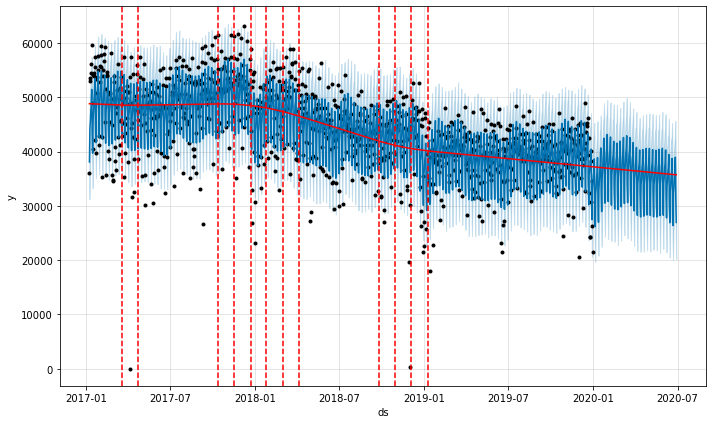

In [72]:
# Otra ventaja de Prophet es que identifica aquellos puntos de la serie de tiempo en los cuales hay algún cambio en la tendencia.
# Estos puntos se pueden graficar utilizando un módulo en particular, tal cual se implementa a continuación.

from fbprophet.plot import add_changepoints_to_plot

fig = model.plot(prediction)

a = add_changepoints_to_plot(fig.gca(),model,prediction)

## Cambios en la tendencia de la Serie de Tiempo

* Con esta implementación sumamente interesante, podemos analizar esos puntos en el tiempo en los cuales la tendencia sufre modificaciones considerables. Es esta implementación de negocio en particular, debemos recordar que estamos analizando el flujo vehicular en una autopista en particular (Illia) y sólo para pago en efectivo.

* Teniendo en mente la consideración anterior, podríamos analizar el por qué de esos cambios en la tendencia y de manera bastante abrupta. Algunas hipotésis que se nos ocurren es averiguar si hubo alguna promoción para migrar al pago electrónico (Telepase), y que eso haya provocado una baja en la cantidad de pasos que abonan en efectivo. Recordar que si considerabamos todos los medios de pago no se observaba una tendencia tan evidente a la baja como considerando sólo el pago en efectivo. Profundizar sobre estos temas podría ser una buena manera de continuar con este trabajo.

In [73]:
# Implementamos validación cruzada.

from fbprophet.diagnostics import cross_validation

df_cv = cross_validation( model, horizon='30 days', period='15 days', initial='90 days')

# ------- Detalle de hiperparámetros seteados --------- #
# Horizon: por que cantidad de día vamos a implementar validación cruzada. En este caso: 365 días.
# Period: según la documentación, una buena práctica es colocar 0.5 de horizon.
# Initial: relacionado a la cantidad de días que queremos en el análisis. Buena práctica según documentación es 3 * horizon.

df_cv.head()

INFO:fbprophet:Making 65 forecasts with cutoffs between 2017-04-15 00:00:00 and 2019-12-01 00:00:00
100%|██████████| 65/65 [03:23<00:00,  3.13s/it]


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-04-16,27024.708563,18432.948884,35343.037290,42272.0,2017-04-15
1,2017-04-17,36425.470940,27658.246033,44482.282479,47573.0,2017-04-15
2,2017-04-18,33161.170791,25010.390079,41960.973991,49557.0,2017-04-15
3,2017-04-19,33170.717663,24683.442585,41393.003008,50244.0,2017-04-15
4,2017-04-20,27113.311327,18881.382098,35239.300160,54288.0,2017-04-15


## Medidas de performance con Prophet

* Entre las medidas que se utilizarán para evaluar las predicciones están el Error Cuadrático Medio (MSE), la Raíz del Error Cuadrático Medio (RMSE), Error Absoluto Medio (MAE), etc.

* Como ya fue aclarado en el Proyecto 3, en mi caso particular soy mas partidario del RMSE por una cuestión dimensional, y que me arroja una idea más objetiva del modelo en sí.

In [74]:
from fbprophet.diagnostics import performance_metrics

df_performance = performance_metrics(df_cv)
df_performance

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,2.371958e+07,4870.274955,3494.933719,0.083229,0.053648,0.810256
1,4 days,2.538351e+07,5038.204693,3682.831413,0.088120,0.062360,0.794872
2,5 days,2.796074e+07,5287.791177,3782.749659,0.091131,0.066002,0.825641
3,6 days,3.767619e+07,6138.093490,4265.170168,0.104317,0.072603,0.784615
4,7 days,4.353477e+07,6598.088214,4397.600576,0.107657,0.071637,0.784615
5,8 days,4.941291e+07,7029.431355,4442.791731,0.113087,0.066989,0.784615
6,9 days,5.675494e+07,7533.587453,4738.339201,0.119871,0.071225,0.774359
7,10 days,7.297072e+07,8542.290302,5078.619492,0.705233,0.071893,0.753846
8,11 days,8.393256e+07,9161.471326,5353.754545,0.706177,0.081591,0.717949
9,12 days,1.007698e+08,10038.417240,5523.401211,0.707495,0.080171,0.717949


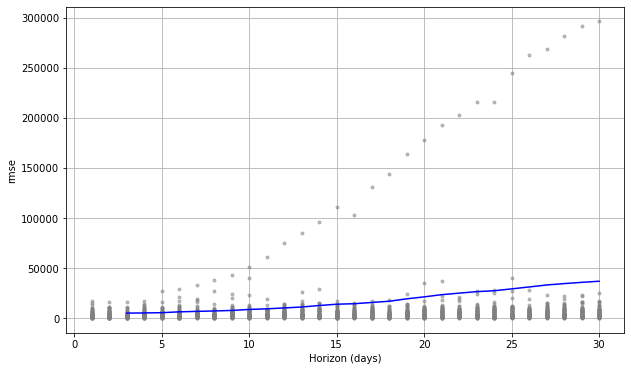

In [75]:
# Para verlo de una manera que brinde más información, se grafica como evoluciona el error de acuerdo al horizonte a predecir.

from fbprophet.plot import plot_cross_validation_metric

df_performance = plot_cross_validation_metric(df_cv,metric='rmse')

#### Conclusiones del error de acuerdo al horizonte a predecir

* En un horizonte corto de tiempo, las predicciones son las mejores que se pudieron obtener de acuerdo a los modelos desarrollados (con un RMSE por debajo de 5.000 pasos diarios, lo que es un muy buen resultado).

* A medida que ampliamos el horizonte sobre el cual realizar las predicciones, vemos que el error (RMSE), comienza a aumentar considerablemente, lo que es totalmente coherente. 

* Se ejecutaron 65 predicciones con distintos cortes en la serie, por lo cual en cada día a predecir hay 65 puntos.

* Como se puede observar en el gráfico el RMSE en general está abajo de 10.000 pasos por día, lo cual podría ser un error bastante aceptable, teniendo el cuenta la simplicidad del método utilizando Prophet.
* A continuación se imprimen los gráficos para otras medidas de error, pero el concepto sigue siendo el mismo.

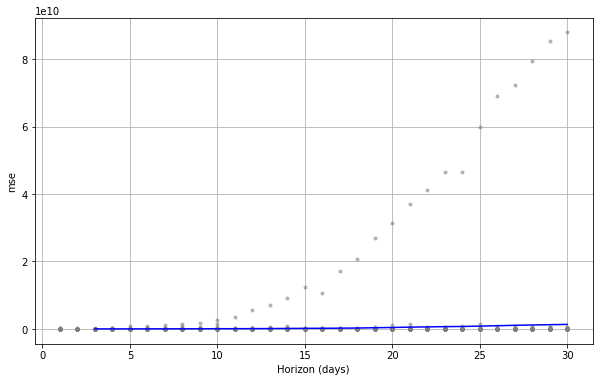

In [76]:
# Utilizando error cuadrático medio.

df_performance2 = plot_cross_validation_metric(df_cv,metric='mse')

## Próximos pasos: como continuar con el proyecto

* Luego de haber analizado e implementado los módulos y librerías que más se utilizan en Series de Tiempo en la actualidad, se consideran interesantes los sigueintes próximos pasos en este proyecto para obtener un modelo que se acerca aún mejor a lo que puede suceder a futuro en los peajes en cuestión.

* Feriados: tratar de obtener un híbrido entre un modelo como el actual (Prophet), focalizando en los días "normales", pero obtener otro modelo utilizando métodos tradicionales como por ejemplo Random Forest para estimar que sucede en los feriados en particular. De esta manera podemos tratar los días no feriados con una serie de tiempo tradicional, lo cual obtiene muy buenos resultados, y por otro analizar que sucederá en cada uno de los feriados. De la concatenación de ambos modelos, creemos, puedo surgir un modelo bastante más preciso y exacto que el actual.

## Cómo se podría agregar el efecto feriados

* Utilizando Prophet realizar esto no es muy dificultoso, lo que pone en evidencia otra ventaja de la utilización de este algoritmo.

1. En primer lugar debemos crear un DataFrame con los feriados de cada año, al que podemos llamar "feriados".
2. Luego, al momento de crear el modelo, que en el proyecto 4 lo realizamos con el código m = Prophet(), debemos realizarlo de esta manera: m = Prophet(holidays = feriados).
3. Luego ejecutamos el .fit y .predict al igual que realizamos el proyecto 4 sobre las fechas futuras deseadas. 
4. Con estos simples pasos habremos incluido en el modelo el efecto de los feriados, que en el caso de los pasos diarios por una cabina de peaje son sumamente importantes. Los pasos diarios están intimamente relacionados con las jornadas laborales y escolares, como vimos en el desarrollo del presenta trabajo.

## Cierre de Proyecto

* Consideramos muy importante la simplicidad de un modelo en su implementación, y esto es lo que sucedió con Prophet. Además las predicciones realizadas son mucho más precisas ya que respetan tanto la ciclicidad en cada día de la semana, como así también en cada semana del año. Consideramos esto último como un factor determinante en la elección del presente modelo.